# 深度解析Qwen2.5模型预测机制：从因果语言建模到Token生成的完整流程

## 概述

本Notebook将通过实际的代码演示，深入探索Qwen2.5模型的预测机制，揭开Transformer模型因果语言建模的预测行为是如何进行的。

### 学习目标
- 理解Qwen2.5模型的加载和基本配置
- 掌握模型输出的logits结构及其含义
- 深入了解因果语言建模中每个位置的预测机制
- 理解为什么模型要为每个位置都生成预测
- 学习实际文本生成时如何利用这些预测

> **提示**: 本次使用的模型参数相对较小，在CPU上也能轻松完成实验！

## 1. 环境准备

首先，让我们准备必要的开发环境和依赖库：

In [34]:
# 导入必要的库
import torch
import time
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
from typing import Optional, Tuple
import gc

# 设置随机种子确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

print("库导入完成！")
print(f"PyTorch版本: {torch.__version__}")
print(f"设备信息: {'CUDA可用' if torch.cuda.is_available() else 'CPU模式'}")

库导入完成！
PyTorch版本: 2.5.1+cu124
设备信息: CUDA可用


## 2. 模型下载

在开始分析之前，我们需要先下载Qwen模型。如果你还没有下载模型，可以按照以下步骤进行：

### 安装必要的依赖

首先在终端中运行以下命令安装所需的Python包：

```bash
pip install modelscope transformers peft diffusers torch accelerate
```

In [35]:
# !pip install modelscope transformers peft diffusers torch accelerate

In [36]:
# 使用ModelScope下载模型（推荐）
# 如果你已经下载了模型，可以跳过这个cell

try:
    from modelscope import snapshot_download
    
    # 下载Qwen2.5-0.5B-Instruct模型到本地
    print("开始下载模型...")
    model_dir = snapshot_download('Qwen/Qwen2.5-0.5B-Instruct', local_dir='./models/Qwen2.5-0.5B-Instruct')
    print(f"模型已下载到: {model_dir}")
    
except ImportError:
    print("ModelScope未安装，请先运行: pip install modelscope")
except Exception as e:
    print(f"下载过程中出现错误: {e}")
    print("你可以手动下载模型或使用其他方法")

开始下载模型...


2026-01-14 15:54:47,627 - modelscope - INFO - Target directory already exists, skipping creation.


模型已下载到: ./models/Qwen2.5-0.5B-Instruct


## 3. 加载Qwen2.5模型

接下来，我们加载已下载的Qwen2.5模型。请根据你的实际情况修改模型路径：

In [37]:
# 模型路径配置
# 请根据你实际下载的路径修改下面的路径
model_path_options = [
    "./models/Qwen2.5-0.5B-Instruct",  # 使用上面下载代码的路径
    # "Qwen/Qwen2.5-0.5B-Instruct",      # 直接从ModelScope加载
]

# 尝试加载模型
model = None
tokenizer = None
model_path = model_path_options[0]  # 默认使用第一个路径

print(f"尝试从 {model_path} 加载模型...")

# 加载tokenizer和模型
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16,  # 使用半精度浮点数节省内存
    device_map="auto",          # 自动分配设备
    trust_remote_code=True      # 信任远程代码
)

print(f"✅ 成功从 {model_path} 加载模型！")


尝试从 ./models/Qwen2.5-0.5B-Instruct 加载模型...
✅ 成功从 ./models/Qwen2.5-0.5B-Instruct 加载模型！


In [38]:
# 设置pad_token
if tokenizer.pad_token is None:
    print("未设置pad_token，使用eos_token作为pad_token")
    tokenizer.pad_token = tokenizer.eos_token

# 显示模型信息
print("\n=== 模型加载完成！===")
print(f"模型参数量: {model.num_parameters():,}")
print(f"模型类型: {model.config.model_type}")
print(f"模型词汇表大小: {len(tokenizer)}")
print(f"模型设备: {next(model.parameters()).device}")
print(f"模型数据类型: {next(model.parameters()).dtype}")


=== 模型加载完成！===
模型参数量: 494,032,768
模型类型: qwen2
模型词汇表大小: 151665
模型设备: cuda:0
模型数据类型: torch.float16


## 4. 模型推理的第一步：理解输入输出

让我们从一个简单的例子开始，看看模型是如何处理输入文本的：

In [39]:
# 准备测试文本
test_prompt = "人工智能的未来发展趋势是"

# 编码输入文本
input_ids = tokenizer.encode(test_prompt, return_tensors="pt").to(model.device)

print(f"输入文本: '{test_prompt}'")
print(f"输入token IDs: {input_ids}")
print(f"输入tokens: {tokenizer.convert_ids_to_tokens(input_ids[0])}")
print(f"序列长度: {input_ids.shape[1]}")

# 显示每个token的详细信息
print("\n=== Token详细信息 ===")
for i, token_id in enumerate(input_ids[0]):
    token_text = tokenizer.decode([token_id])
    print(f"位置 {i}: ID={token_id}, Token='{token_text}'")

输入文本: '人工智能的未来发展趋势是'
输入token IDs: tensor([[104455,   9370, 100353, 108616,  20412]], device='cuda:0')
输入tokens: ['äººå·¥æĻºèĥ½', 'çļĦ', 'æľªæĿ¥', 'åıĳå±ķè¶ĭåĬ¿', 'æĺ¯']
序列长度: 5

=== Token详细信息 ===
位置 0: ID=104455, Token='人工智能'
位置 1: ID=9370, Token='的'
位置 2: ID=100353, Token='未来'
位置 3: ID=108616, Token='发展趋势'
位置 4: ID=20412, Token='是'


## 5. 深入理解模型输出结构

现在让我们看看模型的完整输出结构，这是理解预测机制的关键：

In [40]:
# 获取模型输出
with torch.no_grad():
    outputs = model(input_ids)
    
    # 分析输出结构
    print("=== 模型输出结构分析 ===")
    print(f"输出类型: {type(outputs)}")
    print(f"输出包含的主要组件:")
    print(f"  - logits: {outputs.logits.shape}")
    print(f"  - past_key_values: {type(outputs.past_key_values)}")
    print(f"  - hidden_states: {outputs.hidden_states}")
    print(f"  - attentions: {outputs.attentions}")
    
    print("\n=== Logits维度详解 ===")
    print(f"Logits形状: {outputs.logits.shape}")
    print(f"各维度含义:")
    print(f"  第1维 (batch_size): {outputs.logits.shape[0]} - 批次大小")
    print(f"  第2维 (sequence_length): {outputs.logits.shape[1]} - 序列长度") 
    print(f"  第3维 (vocab_size): {outputs.logits.shape[2]} - 词汇表大小")

=== 模型输出结构分析 ===
输出类型: <class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
输出包含的主要组件:
  - logits: torch.Size([1, 5, 151936])
  - past_key_values: <class 'transformers.cache_utils.DynamicCache'>
  - hidden_states: None
  - attentions: None

=== Logits维度详解 ===
Logits形状: torch.Size([1, 5, 151936])
各维度含义:
  第1维 (batch_size): 1 - 批次大小
  第2维 (sequence_length): 5 - 序列长度
  第3维 (vocab_size): 151936 - 词汇表大小


In [41]:
# 查看每个位置的预测
with torch.no_grad():
    outputs = model(input_ids)
    
    print("=== 每个位置的最高概率预测 ===")
    for i in range(outputs.logits.shape[1]):
        predicted_token_id = outputs.logits[0, i, :].argmax()
        predicted_token_text = tokenizer.decode([predicted_token_id])
        
        # 获取当前位置的输入上下文
        current_context = tokenizer.decode(input_ids[0][:i+1])
        
        print(f"位置 {i}: '{predicted_token_text}' (ID: {predicted_token_id})")
        print(f"       基于上下文: '{current_context}'")
        print(f"       预测下一个token: '{predicted_token_text}'")
        print("-" * 50)

=== 每个位置的最高概率预测 ===
位置 0: '的' (ID: 9370)
       基于上下文: '人工智能'
       预测下一个token: '的'
--------------------------------------------------
位置 1: '“' (ID: 2073)
       基于上下文: '人工智能的'
       预测下一个token: '“'
--------------------------------------------------
位置 2: '是什么' (ID: 102021)
       基于上下文: '人工智能的未来'
       预测下一个token: '是什么'
--------------------------------------------------
位置 3: '是什么' (ID: 102021)
       基于上下文: '人工智能的未来发展趋势'
       预测下一个token: '是什么'
--------------------------------------------------
位置 4: '____' (ID: 2130)
       基于上下文: '人工智能的未来发展趋势是'
       预测下一个token: '____'
--------------------------------------------------


## 6. 因果语言建模的深层原理

为什么模型要为每个位置都生成预测呢？让我们通过详细的分析来理解这个设计：

In [42]:
def analyze_predictions_detailed(model, tokenizer, input_ids):
    """详细分析每个位置的预测机制"""
    with torch.no_grad():
        outputs = model(input_ids)
        
        print(f"输入序列: '{tokenizer.decode(input_ids[0])}'")
        print(f"输入tokens: {tokenizer.convert_ids_to_tokens(input_ids[0])}")
        print("=" * 80)
        
        for i in range(outputs.logits.shape[1]):
            # 获取预测结果
            predicted_token_id = outputs.logits[0, i, :].argmax()
            predicted_token_text = tokenizer.decode([predicted_token_id])
            
            # 显示当前位置能看到的上下文
            visible_tokens = tokenizer.convert_ids_to_tokens(input_ids[0][:i+1])
            visible_text = tokenizer.decode(input_ids[0][:i+1])
            
            print(f"📍 位置 {i}:")
            print(f"   可见上下文: '{visible_text}'")
            print(f"   可见tokens: {visible_tokens}")
            print(f"   预测下一个token: '{predicted_token_text}' (ID: {predicted_token_id})")
            
            # 解释预测含义
            if i == 0:
                print(f"   💡 模型看到第1个token后，预测第2个token")
            elif i == outputs.logits.shape[1] - 1:
                print(f"   🎯 模型看到完整输入后，预测下一个新token (用于生成)")
            else:
                print(f"   🔄 模型看到前{i+1}个token后，预测第{i+2}个token")
            
            print("-" * 60)

# 运行详细分析
analyze_predictions_detailed(model, tokenizer, input_ids)

输入序列: '人工智能的未来发展趋势是'
输入tokens: ['äººå·¥æĻºèĥ½', 'çļĦ', 'æľªæĿ¥', 'åıĳå±ķè¶ĭåĬ¿', 'æĺ¯']
📍 位置 0:
   可见上下文: '人工智能'
   可见tokens: ['äººå·¥æĻºèĥ½']
   预测下一个token: '的' (ID: 9370)
   💡 模型看到第1个token后，预测第2个token
------------------------------------------------------------
📍 位置 1:
   可见上下文: '人工智能的'
   可见tokens: ['äººå·¥æĻºèĥ½', 'çļĦ']
   预测下一个token: '“' (ID: 2073)
   🔄 模型看到前2个token后，预测第3个token
------------------------------------------------------------
📍 位置 2:
   可见上下文: '人工智能的未来'
   可见tokens: ['äººå·¥æĻºèĥ½', 'çļĦ', 'æľªæĿ¥']
   预测下一个token: '是什么' (ID: 102021)
   🔄 模型看到前3个token后，预测第4个token
------------------------------------------------------------
📍 位置 3:
   可见上下文: '人工智能的未来发展趋势'
   可见tokens: ['äººå·¥æĻºèĥ½', 'çļĦ', 'æľªæĿ¥', 'åıĳå±ķè¶ĭåĬ¿']
   预测下一个token: '是什么' (ID: 102021)
   🔄 模型看到前4个token后，预测第5个token
------------------------------------------------------------
📍 位置 4:
   可见上下文: '人工智能的未来发展趋势是'
   可见tokens: ['äººå·¥æĻºèĥ½', 'çļĦ', 'æľªæĿ¥', 'åıĳå±ķè¶ĭåĬ¿', 'æĺ¯']
   预测下一个token: '____' (ID: 21

## 7. 设计原理：为什么要这样做？

这种设计背后有三个重要原因：

In [43]:
def explain_training_efficiency(tokenizer):
    """解释训练时的效率优势"""
    print("🎓 训练时的优势:")
    print("   在训练过程中，一个长度为N的序列可以提供N个训练样本")
    print("   例如序列 '人工智能的未来' 可以提供以下训练样本:")
    
    example_text = "人工智能的未来"
    tokens = tokenizer.encode(example_text)
    
    for i in range(len(tokens) - 1):
        input_part = tokenizer.decode(tokens[:i+1])
        target_token = tokenizer.decode([tokens[i+1]])
        print(f"   输入: '{input_part}' → 目标: '{target_token}'")

explain_training_efficiency(tokenizer)

🎓 训练时的优势:
   在训练过程中，一个长度为N的序列可以提供N个训练样本
   例如序列 '人工智能的未来' 可以提供以下训练样本:
   输入: '人工智能' → 目标: '的'
   输入: '人工智能的' → 目标: '未来'


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC



🔒 因果性约束:
   每个位置只能看到它之前的token（包括自己）
   这确保了模型不会 '作弊' - 不能看到未来的信息

   因果掩码示例 (序列长度=5):
   位置  0  1  2  3  4
   0    1  0  0  0  0
   1    1  1  0  0  0
   2    1  1  1  0  0
   3    1  1  1  1  0
   4    1  1  1  1  1

   1表示可以看到，0表示被掩码


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the foll

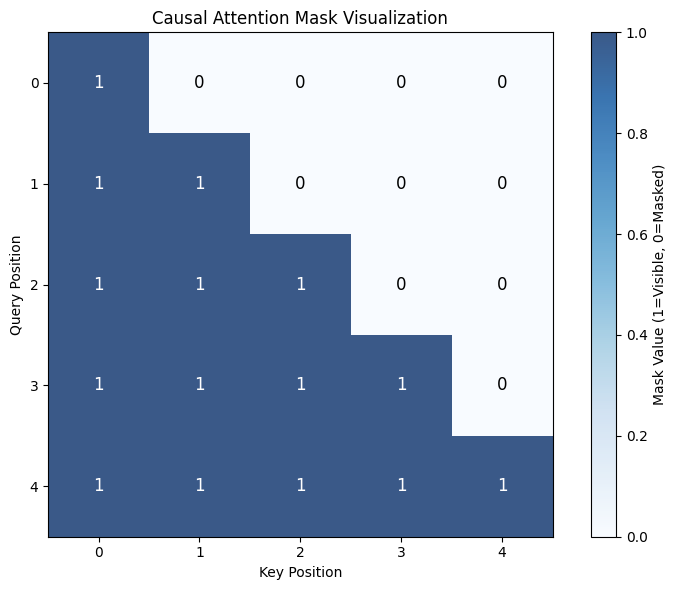

In [44]:
def explain_causal_mask():
    """解释因果注意力掩码"""
    print("\n🔒 因果性约束:")
    print("   每个位置只能看到它之前的token（包括自己）")
    print("   这确保了模型不会 '作弊' - 不能看到未来的信息")
    
    # 创建一个简化的因果掩码示例
    seq_len = 5
    causal_mask = torch.tril(torch.ones(seq_len, seq_len))
    
    print(f"\n   因果掩码示例 (序列长度={seq_len}):")
    print("   位置  0  1  2  3  4")
    for i in range(seq_len):
        mask_str = "  ".join([str(int(causal_mask[i, j])) for j in range(seq_len)])
        print(f"   {i}    {mask_str}")
    
    print("\n   1表示可以看到，0表示被掩码")
    
    return causal_mask

# 可视化因果掩码
mask = explain_causal_mask()

# 绘制掩码矩阵
plt.figure(figsize=(8, 6))
plt.imshow(mask.numpy(), cmap='Blues', alpha=0.8)
plt.title('Causal Attention Mask Visualization')
plt.xlabel('Key Position')
plt.ylabel('Query Position')
plt.colorbar(label='Mask Value (1=Visible, 0=Masked)')

# 添加网格和标注
for i in range(5):
    for j in range(5):
        plt.text(j, i, str(int(mask[i, j])), ha='center', va='center', 
                color='white' if mask[i, j] > 0.5 else 'black', fontsize=12)

plt.tight_layout()
plt.show()

## 8. 实际应用：文本生成

在实际的文本生成中，我们主要关心基于完整输入的预测，即最后一个位置的输出：

In [45]:
def generate_next_tokens(model, tokenizer, text, max_new_tokens=10, temperature=1.0, top_k=50):
    """演示实际的文本生成过程"""
    print(f"🚀 开始生成，初始文本: '{text}'")
    print(f"生成参数: max_tokens={max_new_tokens}, temperature={temperature}, top_k={top_k}")
    print("-" * 60)
    
    # 编码初始文本
    input_ids = tokenizer.encode(text, return_tensors="pt").to(model.device)
    generated_text = text
    
    for step in range(max_new_tokens):
        with torch.no_grad():
            # 模型推理
            outputs = model(input_ids)
            
            # 获取最后一个位置的预测（这是我们关心的）
            next_token_logits = outputs.logits[:, -1, :] / temperature
            
            # 应用top-k采样
            if top_k > 0:
                # 获取top-k的logits
                top_k_logits, top_k_indices = torch.topk(next_token_logits, top_k)
                # 创建掩码，只保留top-k的logits
                mask = torch.full_like(next_token_logits, float('-inf'))
                mask.scatter_(1, top_k_indices, top_k_logits)
                next_token_logits = mask
            
            # 计算概率分布并采样
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, 1)
            
            # 解码新token
            next_token_text = tokenizer.decode(next_token_id[0])
            generated_text += next_token_text
            
            # 显示生成过程
            prob = probabilities[0, next_token_id[0]].item()
            print(f"   步骤 {step+1}: 添加 '{next_token_text}' (概率: {prob:.4f})")
            print(f"           当前文本: '{generated_text}'")
            
            # 更新输入序列
            input_ids = torch.cat([input_ids, next_token_id], dim=-1)
            
            # 简单的停止条件
            if next_token_id[0].item() == tokenizer.eos_token_id:
                print("   🛑 遇到结束符，停止生成")
                break
                
            # 避免生成过长序列
            if input_ids.shape[1] > 100:
                print("   🛑 达到最大长度限制，停止生成")
                break
    
    return generated_text

# 演示生成过程
final_text = generate_next_tokens(model, tokenizer, test_prompt, max_new_tokens=8, temperature=0.7)
print(f"\n✨ 最终生成结果: '{final_text}'")

🚀 开始生成，初始文本: '人工智能的未来发展趋势是'
生成参数: max_tokens=8, temperature=0.7, top_k=50
------------------------------------------------------------
   步骤 1: 添加 '____' (概率: 0.3181)
           当前文本: '人工智能的未来发展趋势是____'
   步骤 2: 添加 '。
' (概率: 0.5571)
           当前文本: '人工智能的未来发展趋势是____。
'
   步骤 3: 添加 'A' (概率: 0.9995)
           当前文本: '人工智能的未来发展趋势是____。
A'
   步骤 4: 添加 '.' (概率: 1.0000)
           当前文本: '人工智能的未来发展趋势是____。
A.'
   步骤 5: 添加 ' ' (概率: 0.4724)
           当前文本: '人工智能的未来发展趋势是____。
A. '
   步骤 6: 添加 '人工智能' (概率: 0.4392)
           当前文本: '人工智能的未来发展趋势是____。
A. 人工智能'
   步骤 7: 添加 '技术' (概率: 0.0411)
           当前文本: '人工智能的未来发展趋势是____。
A. 人工智能技术'
   步骤 8: 添加 '的发展' (概率: 0.0293)
           当前文本: '人工智能的未来发展趋势是____。
A. 人工智能技术的发展'

✨ 最终生成结果: '人工智能的未来发展趋势是____。
A. 人工智能技术的发展'


## 9. 性能优化：KV Cache的作用

在实际应用中，为了提高生成效率，模型使用了KV Cache机制：

In [46]:
def demonstrate_kv_cache(model, tokenizer, test_prompt):
    """演示KV Cache的作用"""
    print("🧠 KV Cache机制:")
    print("   在生成过程中，之前计算的key和value被缓存")
    print("   这避免了重复计算，大大提高了生成速度")
    
    # 演示使用KV Cache的生成
    input_ids = tokenizer.encode(test_prompt, return_tensors="pt").to(model.device)
    
    print(f"\n=== KV Cache演示 ===")
    
    with torch.no_grad():
        # 第一次推理，获取past_key_values
        start_time = time.time()
        outputs = model(input_ids)
        first_inference_time = time.time() - start_time
        
        past_key_values = outputs.past_key_values
        print(f"   输入文本: '{test_prompt}'")
        print(f"past_key_values的形状: {len(past_key_values)}")
        print(f"past_key_values: {past_key_values[0][0].shape}")# (batch_size, num_heads, seq_len, head_dim
        print(f"   初始序列长度: {input_ids.shape[1]}")
        print(f"   KV Cache类型: {type(past_key_values)}")
        print(f"   第一次推理时间: {first_inference_time:.4f}秒")
        
        # 生成下一个token时，只需要计算新token的部分
        next_token_id = torch.argmax(outputs.logits[:, -1, :], dim=-1, keepdim=True)
        
        # 不使用KV Cache的推理
        new_input_ids = torch.cat([input_ids, next_token_id], dim=-1)
        start_time = time.time()
        outputs_no_cache = model(new_input_ids)
        no_cache_time = time.time() - start_time
        
        # 使用KV Cache的推理
        start_time = time.time()
        outputs_with_cache = model(next_token_id, past_key_values=past_key_values)
        cache_time = time.time() - start_time
        
        print(f"   不使用KV Cache的推理时间: {no_cache_time:.4f}秒")
        print(f"   使用KV Cache的推理时间: {cache_time:.4f}秒")
        print(f"   性能提升: {no_cache_time/cache_time:.2f}x")
        
        print(f"\n   使用KV Cache后的输入长度: {next_token_id.shape[1]}")
        print(f"   这样就避免了重新计算整个序列的注意力")
        
        # 验证结果一致性
        logits_no_cache = outputs_no_cache.logits[:, -1, :]
        logits_with_cache = outputs_with_cache.logits[:, -1, :]
        max_diff = torch.max(torch.abs(logits_no_cache - logits_with_cache)).item()
        print(f"   结果差异: {max_diff:.6f} (应该接近0)")

demonstrate_kv_cache(model, tokenizer, test_prompt)

🧠 KV Cache机制:
   在生成过程中，之前计算的key和value被缓存
   这避免了重复计算，大大提高了生成速度

=== KV Cache演示 ===
   输入文本: '人工智能的未来发展趋势是'
past_key_values的形状: 24
past_key_values: torch.Size([1, 2, 5, 64])
   初始序列长度: 5
   KV Cache类型: <class 'transformers.cache_utils.DynamicCache'>
   第一次推理时间: 0.0231秒
   不使用KV Cache的推理时间: 0.0212秒
   使用KV Cache的推理时间: 0.0196秒
   性能提升: 1.08x

   使用KV Cache后的输入长度: 1
   这样就避免了重新计算整个序列的注意力
   结果差异: 0.027344 (应该接近0)


## 10. 概率分布分析

让我们进一步分析模型输出的概率分布：

findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC


📊 位置 -1 的Top-10预测:
   基于上下文: '人工智能的未来发展趋势是'
--------------------------------------------------
    1. '____' (概率: 0.1509, ID: 2130)
    2. '？
' (概率: 0.1070, ID: 94432)
    3. '（' (概率: 0.0847, ID: 9909)
    4. '
' (概率: 0.0460, ID: 198)
    5. '？' (概率: 0.0400, ID: 11319)
    6. '：' (概率: 0.0361, ID: 5122)
    7. '怎' (概率: 0.0273, ID: 99387)
    8. '人工智能' (概率: 0.0217, ID: 104455)
    9. '哪些' (概率: 0.0186, ID: 102224)
   10. '(' (概率: 0.0147, ID: 7)


findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/tmp/ipykernel_39184/3615314277.py:41: UserWarning: Glyph 65311 (\N{FULLWIDTH QUESTION MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
/tmp/ipykernel_39184/3615314277.py:41: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
fin

findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the following families were found: Noto Sans CJK SC
findfont: Generic family 'sans-serif' not found because none of the foll

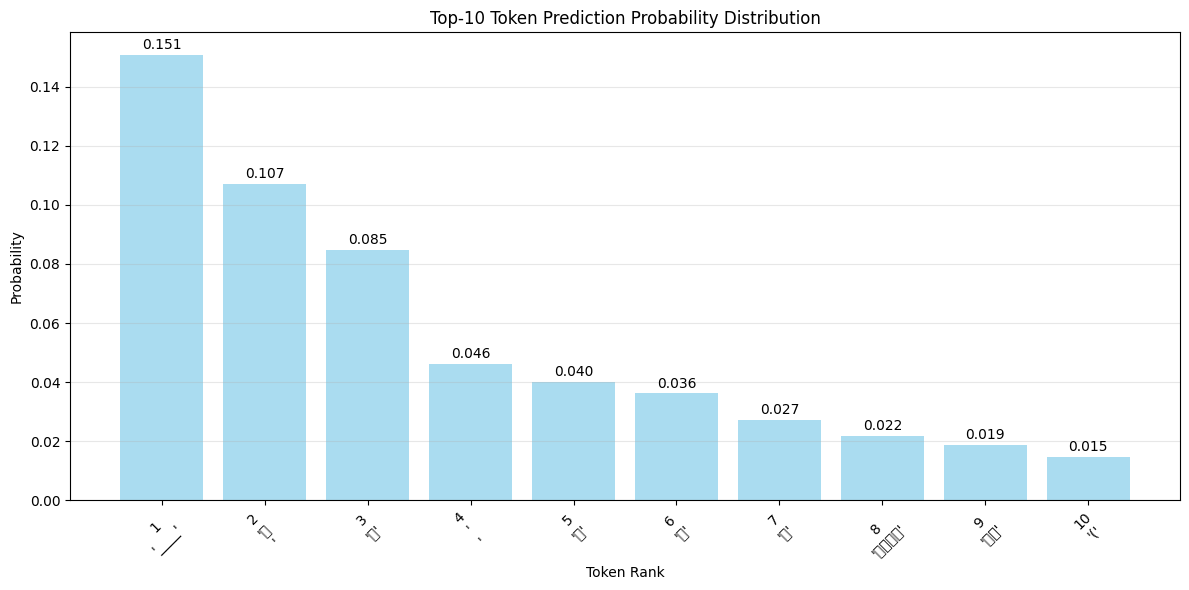

In [47]:
def analyze_probability_distribution(model, tokenizer, input_ids, position=-1, top_k=10):
    """分析指定位置的概率分布"""
    with torch.no_grad():
        outputs = model(input_ids)
        logits = outputs.logits[0, position, :]  # 获取指定位置的logits
        
        # 应用softmax得到概率分布
        probabilities = torch.softmax(logits, dim=-1)
        
        # 获取top-k概率最高的token
        top_probs, top_indices = torch.topk(probabilities, top_k)
        
        print(f"📊 位置 {position} 的Top-{top_k}预测:")
        print(f"   基于上下文: '{tokenizer.decode(input_ids[0])}'")
        print("-" * 50)
        
        for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
            token_text = tokenizer.decode([idx])
            print(f"   {i+1:2d}. '{token_text}' (概率: {prob:.4f}, ID: {idx})")
        
        return top_probs, top_indices

# 分析最后一个位置的概率分布
top_probs, top_indices = analyze_probability_distribution(model, tokenizer, input_ids, position=-1)

# 可视化概率分布
plt.figure(figsize=(12, 6))
top_tokens = [tokenizer.decode([idx]) for idx in top_indices[:10]]
top_probs_numpy = top_probs[:10].cpu().numpy()

plt.bar(range(10), top_probs_numpy, alpha=0.7, color='skyblue')
plt.xlabel('Token Rank')
plt.ylabel('Probability')
plt.title('Top-10 Token Prediction Probability Distribution')
plt.xticks(range(10), [f"{i+1}\n'{token}'" for i, token in enumerate(top_tokens)], rotation=45)
plt.grid(axis='y', alpha=0.3)
# 添加数值标签
for i, prob in enumerate(top_probs_numpy):
    plt.text(i, prob + 0.001, f'{prob:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [48]:
# 对比不同位置的预测质量
print("\n=== 不同位置的预测对比 ===")

with torch.no_grad():
    outputs = model(input_ids)
    
    for pos in range(outputs.logits.shape[1]):
        logits = outputs.logits[0, pos, :]
        probabilities = torch.softmax(logits, dim=-1)
        
        # 计算概率分布的熵（不确定性指标）
        entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-10))
        
        # 获取最高概率
        max_prob = torch.max(probabilities)
        
        # 获取预测的token
        predicted_id = torch.argmax(probabilities)
        predicted_token = tokenizer.decode([predicted_id])
        
        # 当前位置的上下文
        context = tokenizer.decode(input_ids[0][:pos+1])
        
        print(f"位置 {pos}: 上下文='{context}'")
        print(f"        预测='{predicted_token}' (概率: {max_prob:.4f})")
        print(f"        熵值: {entropy:.4f} (越低越确定)")
        print("-" * 60)


=== 不同位置的预测对比 ===
位置 0: 上下文='人工智能'
        预测='的' (概率: 0.0867)
        熵值: nan (越低越确定)
------------------------------------------------------------
位置 1: 上下文='人工智能的'
        预测='“' (概率: 0.0670)
        熵值: nan (越低越确定)
------------------------------------------------------------
位置 2: 上下文='人工智能的未来'
        预测='是什么' (概率: 0.1237)
        熵值: nan (越低越确定)
------------------------------------------------------------
位置 3: 上下文='人工智能的未来发展趋势'
        预测='是什么' (概率: 0.2634)
        熵值: nan (越低越确定)
------------------------------------------------------------
位置 4: 上下文='人工智能的未来发展趋势是'
        预测='____' (概率: 0.1509)
        熵值: nan (越低越确定)
------------------------------------------------------------


## 总结与思考

通过这次深入的分析，我们揭示了Qwen2.5模型预测机制的几个关键要点：

### 核心发现

1. **多位置预测**: 模型为序列中的每个位置都生成对下一个token的预测
2. **因果性约束**: 每个位置只能看到它之前的信息，确保了时序的合理性
3. **训练效率**: 这种设计允许从单个序列中获得多个训练样本
4. **生成应用**: 在实际生成时，我们主要关注基于完整输入的最后一个位置的预测

### 实际应用价值

理解这些机制对于：
- **模型优化**: 帮助开发者更好地调优模型参数
- **应用开发**: 指导如何更高效地使用模型进行文本生成
- **问题诊断**: 当模型表现异常时，能够更准确地定位问题

### 扩展思考

1. **不同位置的预测质量**: 从我们的分析可以看出，序列后面的位置通常有更多上下文信息，预测可能更准确
2. **注意力权重分析**: 可以进一步分析不同位置如何影响最终预测
3. **多模态扩展**: 这种机制如何适用于图文多模态模型

> **技术要点回顾**:
> - Transformer模型使用因果语言建模，为每个位置预测下一个token
> - 训练时利用所有位置的预测提高效率，推理时主要关注最后位置
> - KV Cache机制在生成过程中显著提升性能
> - 理解这些机制有助于更好地应用和优化大语言模型

In [49]:
# 清理GPU内存（如果使用GPU）
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
print("🎉 实验完成！")
print("\n希望这个Notebook帮助你更好地理解了Qwen2.5模型的预测机制！")
print("\n相关资源:")
print("- Transformers官方文档: https://huggingface.co/docs/transformers/")
print("- Qwen2.5模型介绍: https://qwenlm.github.io/")
print("- 因果语言建模详解: https://huggingface.co/learn/nlp-course/chapter7/6")

🎉 实验完成！

希望这个Notebook帮助你更好地理解了Qwen2.5模型的预测机制！

相关资源:
- Transformers官方文档: https://huggingface.co/docs/transformers/
- Qwen2.5模型介绍: https://qwenlm.github.io/
- 因果语言建模详解: https://huggingface.co/learn/nlp-course/chapter7/6
